In [167]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import time
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from RBM import RBM
from scipy.integrate import simps


device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [170]:
def TMCSample(v, w_hat, N, V,it_mcmc=100, ß=1):
    vtab = torch.zeros((v.shape[0],it_mcmc+1))
    vtab[:,0] = v[:,0]
    v_curr = v.cpu()
    V = V.cpu()
    norm = 1/(v_curr.shape[0]**0.5)
    w_curr = (torch.dot(v_curr[:,0], V)*norm).item()
    
    #print(w_curr)
    index = torch.randperm(v_curr.shape[0])
    for t in range(it_mcmc):
        start = time.time()
        h_curr, _ = myRBM.SampleHiddens01(v_curr.cuda())
        h_i = (torch.mm(myRBM.W.T, h_curr)+myRBM.vbias.reshape(v.shape[0],1)).cpu()
        w_next = w_curr
        
        v_next = torch.clone(v_curr)
        index = torch.randperm(v_curr.shape[0])
    
        for idx in range(v_curr.shape[0]):
            #i = index[idx]
            i = idx
            # start_2 = time.time()
            v_next[i] = 1-v_curr[i]
            #print(h_i.shape)
            #print(w_hat)
            #print("bef ",w_next)
            w_next += ((2*v_next[i,0]-1)*V[i]*norm).item()
            #print("aft ",w_next)
            #print(w_curr-w_next)
            #w_next = torch.dot(v_next[:,0], V)/(v.shape[0]**0.5)
            # On calcul -DeltaE
            ΔE = ß*((2*v_next[i]-1)*h_i[i])-(N/2)*((w_hat-w_next)**2-(w_hat-w_curr)**2)
            # tmp = torch.exp(ß*((2*v_next[i]-1)*h_i[i])-N*((w_hat-w_next)**2-(w_hat-w_curr)**2))
            #print(tmp.shape)
            # prob = min(1, tmp)
            if ΔE >= 0:      
                #print("t1")
                v_curr[i] = v_next[i]
                w_curr = w_next
            elif (torch.rand(1,1, device = torch.device("cpu"))<torch.exp(ΔE)):
                #print("t1")
                v_curr[i] = v_next[i]
                w_curr = w_next
            else:
                w_next = w_curr
                v_next[i] = 1-v_curr[i]
                            
            #print("upd 1 var exec time = ", start_2-time.time())
        vtab[:,t+1] = v_curr[:,0]
        #print("it_mcmc exec time = ", time.time()-start)
    return v_curr, h_curr, vtab

In [29]:
W = np.genfromtxt('../data/C1d5c/rbm_W.dat').T
vbias = np.genfromtxt('../data/C1d5c/rbm_vis.dat')
hbias = -np.genfromtxt('../data/C1d5c/rbm_hid.dat')
data = np.genfromtxt('../data/C1d5c/data_5.dat')
data = (data+1)/2

In [30]:
lr = 0.01
l2 = 0
NGibbs = 10
annSteps = 0
mb_s = 500
num_pcd = 500
Nh = W.shape[0]
Nv = W.shape[1]

ep_max = 100

In [55]:
myRBM = RBM(num_visible=Nv,
				num_hidden=Nh,
				device=device,
				lr=lr,
				#regL2=l2,
				gibbs_steps=NGibbs,
				#anneal_steps=annSteps,
				UpdCentered=True,
				mb_s=mb_s,
				num_pcd=num_pcd)

myRBM.W = torch.tensor(4*W).float().cuda()
myRBM.vbias = torch.tensor(2*vbias - 2*W.sum(0)).float().to(device)
myRBM.hbias = torch.tensor(2*hbias - 2*W.sum(1)).float().to(device)
U, S, V = torch.svd(torch.tensor(4*W).float().cuda())


(2000, 1000)


(0.0, 0.05)

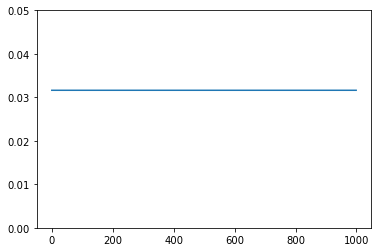

In [60]:
print(data.shape)
plt.plot(V[:,0].cpu())
plt.ylim(0,0.05)

(array([  8.,  48., 128.,  67.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,  18., 102., 203., 131.,  46.,   6.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,  32., 125., 139.,  50.,   8.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,  29.,
         31.,   5.,  26., 415., 359.,  10.]),
 array([ 4.869907 ,  5.379666 ,  5.8894253,  6.399184 ,  6.908943 ,
         7.418702 ,  7.9284616,  8.43822  ,  8.94798  ,  9.457739 ,
         9.967498 , 10.477257 , 10.987016 , 11.496775 , 12.006534 ,
        12.516293 , 13.026052 , 13.535811 , 14.04557  , 14.555329 ,
        15.065088 , 15.574847 , 16.084606 , 16.594366 , 17.104124 ,
        17.613884 , 18.123642 , 18.633402 , 19.143162 , 19.65292  ,
        20.16268  , 20.672438 , 21.182198 , 21.691956 , 22.201715 ,
        22.711475 , 23.221233 , 23.730993 , 24.240751 , 24.750511 ,
        25.26027  , 25.77003  , 26.279787 , 26.789547 , 27.299307 ,
        27.809065 , 28.318825 , 28.828583 , 29

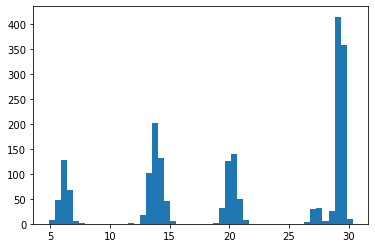

In [65]:
Xsc=torch.mm(torch.tensor(data).to(device).float(),V)
# plt.scatter(Xsc[:,0].cpu(),Xsc[:,3].cpu())
plt.hist(Xsc[:,0].cpu().numpy(),bins=50)

In [57]:
S

tensor([4.7320e+01, 1.6731e-06, 4.5890e-14, 1.4879e-21, 1.5403e-27, 1.2037e-36,
        5.3109e-43, 4.6383e-43, 3.3211e-43, 3.3211e-43, 1.9898e-43, 1.9898e-43,
        1.3312e-43, 6.5861e-44, 6.5861e-44, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00], device='cuda:0')

In [6]:
start_points = torch.bernoulli(torch.rand(myRBM.Nv, 1000, device = device))
arrival,_,_,_ = myRBM.Sampling(start_points, it_mcmc = 1000)
proj_gen = torch.mm(arrival.T, V).cpu()/myRBM.Nv**0.5

In [106]:
start = torch.bernoulli(torch.rand(myRBM.Nv, 1, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat = torch.linspace(0,1,steps =100)
y = []
N = 20000
for i in range(len(w_hat)):
    print(i)
    tmpv, tmph, vtab= TMCSample(start, w_hat[i], N,V0, it_mcmc = 100)
    y.append(torch.mean(torch.dot(vtab[:,-60].T.cpu(), V0.cpu())))
y = np.array(y)/myRBM.Nv**0.5

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.003518589028696468


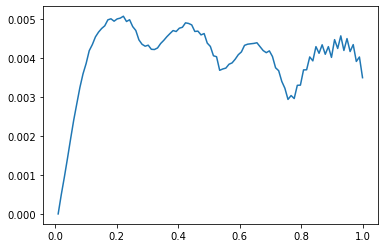

In [107]:


res=np.zeros(len(w_hat)-1)
print(simps(y-w_hat.numpy(), w_hat.numpy()))
for i in range(1,len(w_hat)):
    res[i-1] = simps(y[:i]-w_hat[:i].numpy(), w_hat[:i].numpy())
const = 1/res[-1]
p_m = np.exp(N*res)*const
potential = res + (1/N)*np.log(res[-1])
#plt.plot(w_hat[1:], potential)
plt.plot(w_hat[1:], res)
p_m;

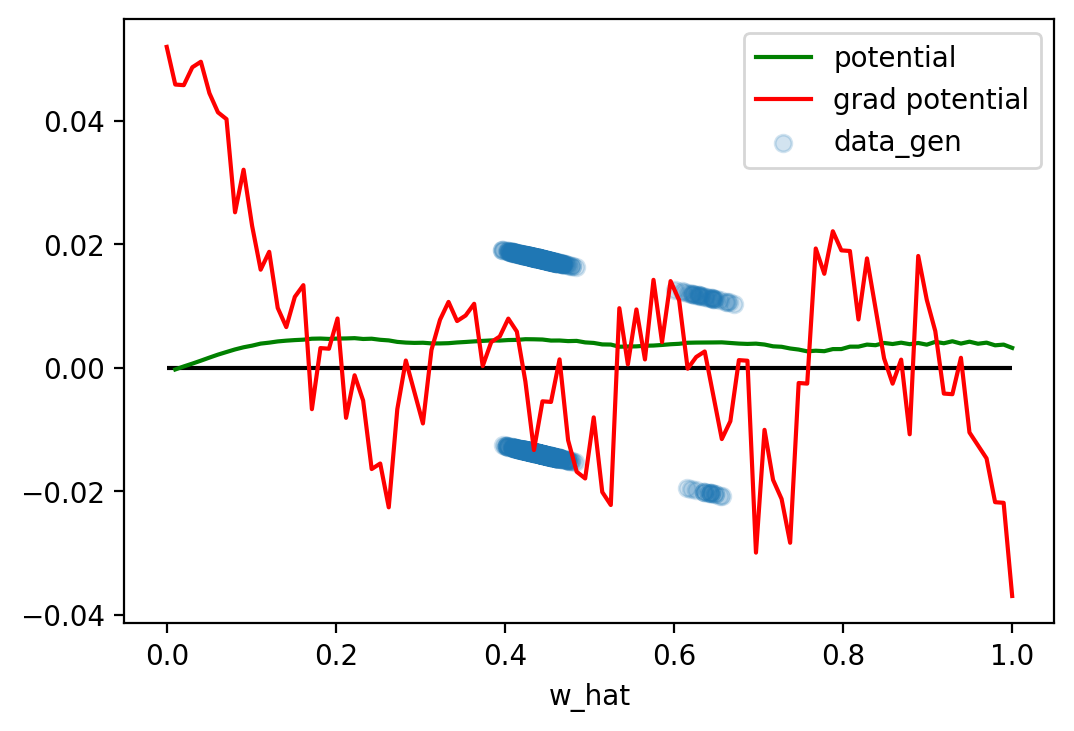

In [108]:
proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
plt.figure(dpi = 200)
plt.plot(w_hat[1:], potential, color = "green", label = "potential")
plt.plot(w_hat,y-w_hat.numpy(),color='red', label = "grad potential")
plt.hlines(0,0,1, color = 'black')
plt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
rdm_y = torch.randn(proj_data[:,0].shape)/20
# plt.scatter(proj_data[:,0], proj_data[:,1], alpha = 0.2, label = 'data')
rdm_y = torch.randn(proj_data[:,0].shape)/20
#plt.plot(proj_data[:,0],rdm_y,'o',markersize=1,alpha=0.3)
# plt.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=100)
plt.xlabel("w_hat")
plt.legend()

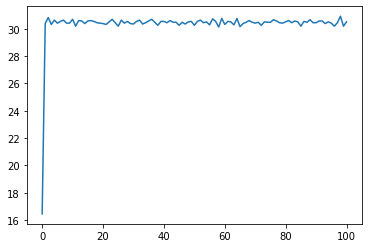

In [109]:
proj_new = torch.mm(vtab.cpu().T, V.cpu())
plt.plot(proj_new[:,0])

-0.0023842684


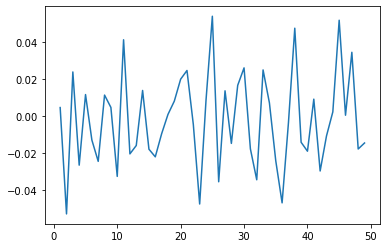

In [163]:
mea=proj_new[:,0]
N=len(mea)
mea-=np.average(mea[int(0.9*N):])


xx=range(1,50)
C=[torch.mean((mea[t:]*mea[:-t])) for t in xx]

plt.plot(xx, C)

print(np.mean(C))

In [110]:
w_hat.shape

torch.Size([100])

In [179]:
start = torch.bernoulli(torch.rand(myRBM.Nv, 1, device = device))
V0 = V[:,0]
# w_hat = torch.dot(start.T, V)[0:,]
w_hat = torch.linspace(0,1,steps =100)
y_2 = []
N = 10000
for i in range(len(w_hat)):
    print(i)
    tmpv, tmph, vtab= TMCSample(start, w_hat[i], N,V0, it_mcmc = 30)
    y_2.append(torch.mean(torch.dot(vtab[:,-20].T.cpu(), V0.cpu())))
y_2 = np.array(y_2)/myRBM.Nv**0.5

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


0.007207986909630551
1.0000000000000002


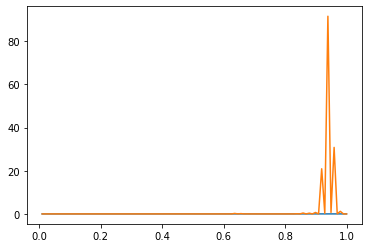

In [180]:

res_2=np.zeros(len(w_hat)-1)
print(simps(y_2-w_hat.numpy(), w_hat.numpy()))
for i in range(1,len(w_hat)):
    res_2[i-1] = simps(y_2[:i]-w_hat[:i].numpy(), w_hat[:i].numpy())
const = simps(np.exp(N*res_2), w_hat[:len(w_hat)-1].numpy())
p_m = np.exp(N*res_2)/const
potential = res_2 + (1/N)*np.log(const)
#plt.plot(w_hat[1:], potential)
plt.plot(w_hat[1:], res_2)
plt.plot(w_hat[1:],p_m)
print(simps(p_m, w_hat[:len(w_hat)-1]))

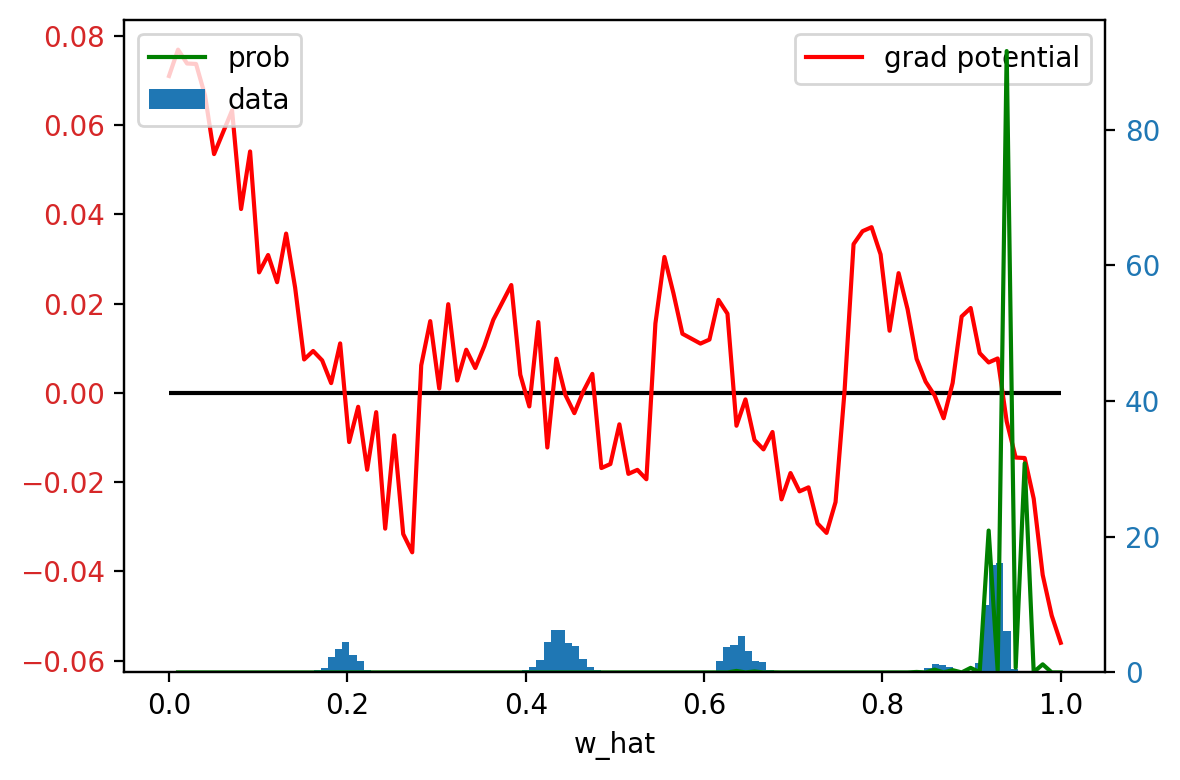

'\nplt.figure(dpi = 200)\nplt.plot(w_hat[1:], potential, color = "green", label = "potential")\nplt.plot(w_hat,y_2-w_hat.numpy(),color=\'red\', label = "grad potential")\nplt.hlines(0,0,1, color = \'black\')\nplt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = \'data_gen\')\nrdm_y = torch.randn(proj_data[:,0].shape)/20\n#\xa0plt.scatter(proj_data[:,0], proj_data[:,1], alpha = 0.2, label = \'data\')\nrdm_y = torch.randn(proj_data[:,0].shape)/20\n#plt.plot(proj_data[:,0],rdm_y,\'o\',markersize=1,alpha=0.3)\nplt.hist(proj_data[:,0].numpy(), label = \'data\', density=True, bins=100)\nplt.xlabel("w_hat")\nplt.legend()\n'

In [181]:


proj_data =torch.mm(torch.tensor(data, device = device, dtype = dtype), V).cpu()/myRBM.Nv**0.5
fig, ax1 = plt.subplots(dpi = 200)

color = 'tab:red'
ax1.set_xlabel("w_hat")
#ax1.set_ylabel('exp', color=color)
ax1.plot(w_hat,y_2-w_hat.numpy(),color='red', label = "grad potential")
ax1.hlines(0,0,1, color = 'black')
#ax1.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
rdm_y = torch.randn(proj_data[:,0].shape)/20
ax2.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=100)
ax2.plot(w_hat[1:], p_m, color = "green", label = "prob")

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
plt.show()
'''
plt.figure(dpi = 200)
plt.plot(w_hat[1:], potential, color = "green", label = "potential")
plt.plot(w_hat,y_2-w_hat.numpy(),color='red', label = "grad potential")
plt.hlines(0,0,1, color = 'black')
plt.scatter(proj_gen[:,0], proj_gen[:,1],alpha=0.2, label = 'data_gen')
rdm_y = torch.randn(proj_data[:,0].shape)/20
# plt.scatter(proj_data[:,0], proj_data[:,1], alpha = 0.2, label = 'data')
rdm_y = torch.randn(proj_data[:,0].shape)/20
#plt.plot(proj_data[:,0],rdm_y,'o',markersize=1,alpha=0.3)
plt.hist(proj_data[:,0].numpy(), label = 'data', density=True, bins=100)
plt.xlabel("w_hat")
plt.legend()
'''

In [178]:
(1/0.05)**2

400.0